In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
device = "cuda"

In [2]:
class config:
    model1 = "resnet18"
    model2 = "resnet18"
    batchsize = 32
    WEIGHT_DECAY = 0.01
    EPOCHS = 10
class path:
    maindir = "/kaggle/input/gsoclensing/dataset/train"
    valid = "/kaggle/input/gsoclensing/dataset/val"

In [3]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [4]:
import torch
from tqdm import tqdm
import timm
import torch.nn as nn
from torchsummary import summary
from torchvision import transforms
import time
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [5]:
data = np.load('/kaggle/input/gsoclensing/dataset/train/no/5955.npy')

In [6]:
data.shape

(1, 150, 150)

In [7]:
train_data = {}
for i in (range(len(os.listdir(path.maindir)))):
    for j in tqdm(os.listdir(os.path.join(path.maindir,os.listdir(path.maindir)[i]))):
        train_data[os.path.join(os.path.join(path.maindir,os.listdir(path.maindir)[i],j))]=i
        
valid_data = {}
for i in (range(len(os.listdir(path.valid)))):
    for j in tqdm(os.listdir(os.path.join(path.valid,os.listdir(path.valid)[i]))):
        valid_data[os.path.join(os.path.join(path.valid,os.listdir(path.valid)[i],j))]=i


100%|██████████| 2500/2500 [00:00<00:00, 3078.12it/s]


In [8]:
imgtrans = transforms.Compose([
    transforms.ToPILImage(mode='L'),
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
]
)

In [9]:
class CustomDataset():
    def __init__(self,dictt,trans):
        self.trans = trans
        self.dic = dictt
    def __len__(self):
        return len(self.dic)
    def __getitem__(self,idx):
        keys = list(self.dic)[idx]
        data = np.load(keys)
        data = torch.tensor(data)
        data = self.trans(data)
        values = list(self.dic.values())[idx]
        return {
            "data":torch.tensor(data,dtype = torch.float32),
            "value":torch.tensor(values)
        }

    
            

In [10]:
custom = CustomDataset(train_data,imgtrans)


In [11]:
len(custom)

30000

In [12]:
custom[0]["data"]

tensor([[[-0.9686, -0.9843, -0.9843,  ..., -0.9765, -0.9922, -0.9843],
         [-0.9765, -0.9843, -0.9686,  ..., -0.9765, -0.9843, -0.9765],
         [-0.9843, -0.9765, -0.9686,  ..., -0.9765, -0.9843, -0.9922],
         ...,
         [-0.9686, -0.9922, -0.9765,  ..., -0.9843, -0.9843, -0.9843],
         [-0.9765, -0.9922, -0.9843,  ..., -0.9922, -0.9765, -0.9686],
         [-0.9686, -0.9686, -0.9686,  ..., -0.9843, -0.9922, -0.9686]]])

In [13]:
def deltamat(shape):
    kk = np.zeros((shape,shape))
    for i in range(shape):
        for j in range(shape):
            kk[i][j] = (((i+1)**2)+((j+1)**2))**0.5
    return torch.tensor(kk,dtype = torch.float32)
positiontensor = deltamat(150)
positiontensor = positiontensor.unsqueeze(dim=0)
positiontensor=positiontensor.to("cuda")

In [14]:
class SimpleModel(nn.Module):
    def __init__(self,positionmat,batchsize = config.batchsize):
        super(SimpleModel,self).__init__()
        self.positionmat = positionmat
        self.batchsize = batchsize
        self.encoder = timm.create_model(
            config.model1,
            pretrained = True,
            drop_rate = 0.1
        )
        self.encoder.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.encoder.fc = nn.Linear(512,150*150,bias=True)
        
        self.doosramodel = timm.create_model(
            config.model2,
            pretrained = True,
            drop_rate = 0.1
        )
        self.doosramodel.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.doosramodel.fc = nn.Linear(in_features=512, out_features=3, bias=True)
    
    def lensingequation(self,angular,image):
        sourcedimage = image-angular
        return sourcedimage
    
    def forward(self,x):
        k = self.encoder(x)
        #print(k.shape)
        batch = k.shape[0]
        k = k.reshape(batch,1,150,150)
        angulardistort = k*self.positionmat
        #print(angulardistort.shape)
        sourced_image = self.lensingequation(x,angulardistort)
        #twochannelimg = torch.cat((x,sourced_image),dim=1)
        features = self.doosramodel(sourced_image)
        return features
        

In [15]:
#testing the model for a random tensor of shape (batch,channel,150,150)
simple = SimpleModel(positiontensor,32).to(device)
xx = torch.randn(size=(45,1,150,150)).to(device)

simple(xx)

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

tensor([[ 0.3605,  0.5915,  0.2310],
        [-0.0888,  0.0910, -0.0973],
        [ 0.1548,  0.2092,  0.2174],
        [ 0.1590,  0.2008,  0.3018],
        [ 0.0220,  0.1872,  0.2147],
        [-0.0056,  0.1168,  0.1414],
        [ 0.0789,  0.2256,  0.3321],
        [ 0.1015,  0.4501,  0.3196],
        [ 0.1249,  0.1740,  0.4148],
        [ 0.1579,  0.0443,  0.1296],
        [ 0.1672,  0.3182,  0.2052],
        [ 0.1823,  0.2683,  0.3271],
        [ 0.0418,  0.2380,  0.4011],
        [ 0.1003,  0.2566,  0.1934],
        [-0.0710,  0.0821,  0.3909],
        [ 0.0608,  0.1548,  0.2912],
        [-0.0081,  0.1286,  0.4125],
        [-0.0682, -0.0347,  0.2376],
        [ 0.1588,  0.2204,  0.1529],
        [ 0.1559,  0.1914,  0.4097],
        [ 0.3718,  0.3818,  0.6157],
        [ 0.0260,  0.2912,  0.2836],
        [ 0.0326,  0.1922,  0.3943],
        [ 0.3272,  0.1607,  0.1298],
        [ 0.0311,  0.3219,  0.1076],
        [ 0.1783,  0.1712,  0.1675],
        [ 0.4752,  0.3558,  0.3510],
 

In [16]:
traindataset = CustomDataset(train_data,imgtrans)
validdataset  =CustomDataset(valid_data,imgtrans)

trainloader = DataLoader(traindataset,batch_size = 32,shuffle = True)
testloader = DataLoader(validdataset,batch_size = 32,shuffle = True)


In [17]:
from torch.optim.lr_scheduler import OneCycleLR


In [18]:
def trainer(model,trainloader,optimizer,criterion,device):
    model.train()
    iterationloss = 0
    counter = 0
    for data in tqdm(trainloader):
        message = data['data'].to(device)
        target = data['value'].to(device).squeeze()
        optimizer.zero_grad()
        out = model(message)
        loss = criterion(F.log_softmax(out, dim=1), target)
        loss.backward()
        optimizer.step()
        iterationloss+=loss.item()*message.shape[0]
        counter+=message.shape[0]
    return iterationloss/counter

In [19]:
def tester(model, testloader, criterion, device):
    model.eval()
    iteration_loss = 0
    counter = 0
    correct_predictions = 0
    y_true = []
    y_scores = []

    for data in tqdm(testloader):
        message = data['data'].to(device)
        target = data['value'].to(device).squeeze()
        
        with torch.no_grad():
            out = model(message)
            loss = criterion(F.log_softmax(out, dim=1), target)
            iteration_loss += loss.item() * message.shape[0]
            
            predicted_classes = torch.argmax(F.log_softmax(out, dim=1), dim=1)
            correct_predictions += (predicted_classes == target).sum().item()
            
            # Append the labels and probabilities to the list
            y_true.extend(target.cpu().numpy())
            y_scores.extend(F.softmax(out, dim=1).cpu().numpy())  # Probabilities for each class

        counter += message.shape[0]

    accuracy = correct_predictions / counter
    print("Accuracy:", accuracy)
    
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    
    # calculating ROC AUC 
    roc_auc_scores = []
    false_positive_rate = dict()
    true_positive_rate = dict()
    for i in range(y_scores.shape[1]):
        false_positive_rate[i], true_positive_rate[i], _ = roc_curve(y_true == i, y_scores[:, i])
        roc_auc_scores.append(roc_auc_score(y_true == i, y_scores[:, i]))

    # calcuating average ROC AUC across all the classes by one vs all method and taking mean of the 3 classes
    roc_score = np.mean(roc_auc_scores)
    print("ROC AUC Score:", roc_score)
    
    plt.figure(figsize=(8, 6))
    class_dict = {0:"no substructure",1:"spherical substructure",2:"vortex substructure"}
    for i in range(y_scores.shape[1]):
        plt.plot(false_positive_rate[i], true_positive_rate[i], label=f'Class {class_dict[i]} (ROC AUC = {roc_auc_scores[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-Class Classification')
    plt.legend(loc="lower right")
    plt.show()
    
    return iteration_loss / counter

In [20]:
meramodel = SimpleModel(positiontensor,config.batchsize)
meramodel.to(device)
optimizer = torch.optim.RAdam(meramodel.parameters(),lr = 0.005)
criterion = nn.CrossEntropyLoss()
scheduler = scheduler = OneCycleLR(
        optimizer,
        max_lr=0.01,
        epochs=config.EPOCHS,
        steps_per_epoch=938,
        pct_start=0.1,
        anneal_strategy="cos",
        final_div_factor=100)

Epoch no. = 1
--------------------------------------------------------------------------------


100%|██████████| 235/235 [00:58<00:00,  4.04it/s]


Accuracy: 0.3353333333333333
ROC AUC Score: 0.5064226


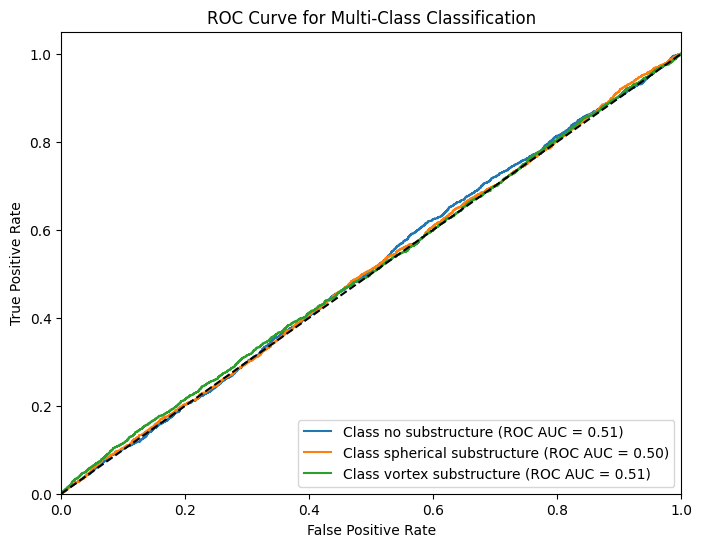

TrainLoss =  1.1017606812795002   ValidationLoss =  1.098844394493103
lr =  0.0004000325764464477
Best Model Saved
Epoch no. = 2
--------------------------------------------------------------------------------


100%|██████████| 235/235 [00:15<00:00, 15.15it/s]


Accuracy: 0.3308
ROC AUC Score: 0.50660556


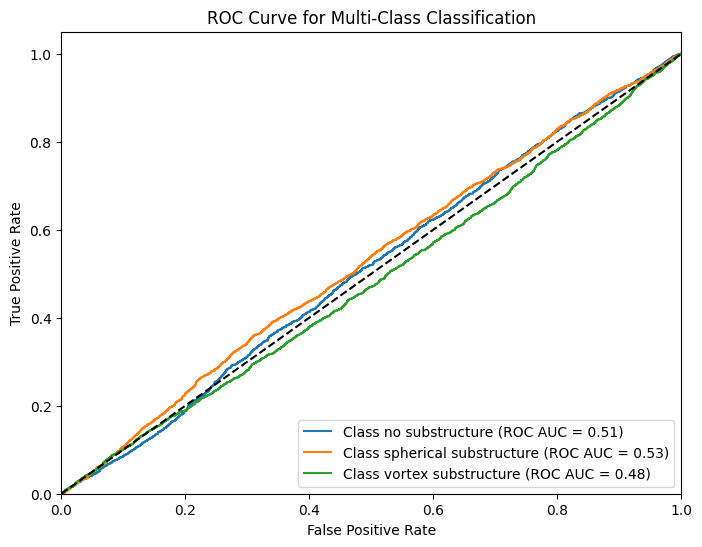

TrainLoss =  1.0987638348897297   ValidationLoss =  1.0986181434631348
lr =  0.0004000325630329239
Best Model Saved
Epoch no. = 3
--------------------------------------------------------------------------------


100%|██████████| 235/235 [00:15<00:00, 14.93it/s]


Accuracy: 0.3566666666666667
ROC AUC Score: 0.5309231866666667


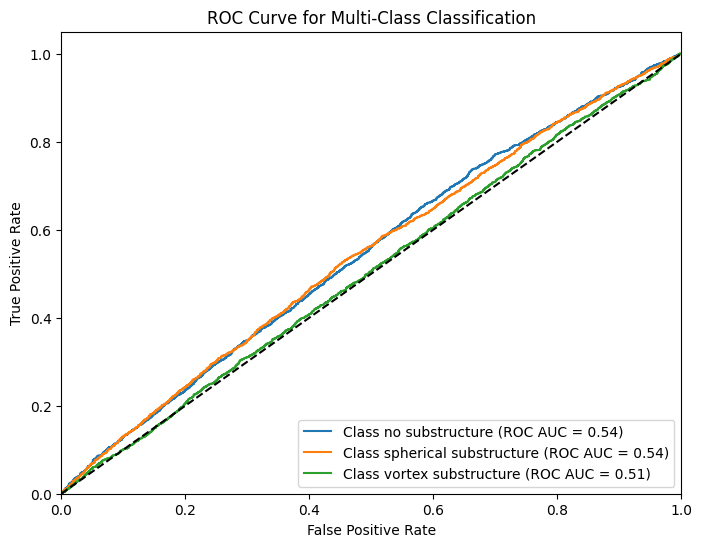

TrainLoss =  1.0977184065500896   ValidationLoss =  1.0958512798945108
lr =  0.0004000323992200232
Best Model Saved
Epoch no. = 4
--------------------------------------------------------------------------------


100%|██████████| 235/235 [00:15<00:00, 15.54it/s]


Accuracy: 0.3777333333333333
ROC AUC Score: 0.5598170933333333


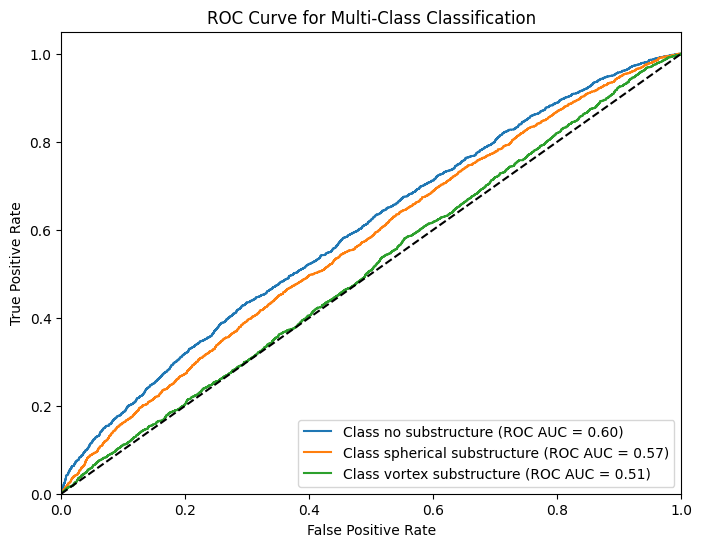

TrainLoss =  1.095487300936381   ValidationLoss =  1.0857637492497763
lr =  0.00040003180548342336
Best Model Saved
Epoch no. = 5
--------------------------------------------------------------------------------


100%|██████████| 235/235 [00:15<00:00, 15.07it/s]


Accuracy: 0.4809333333333333
ROC AUC Score: 0.7127273466666666


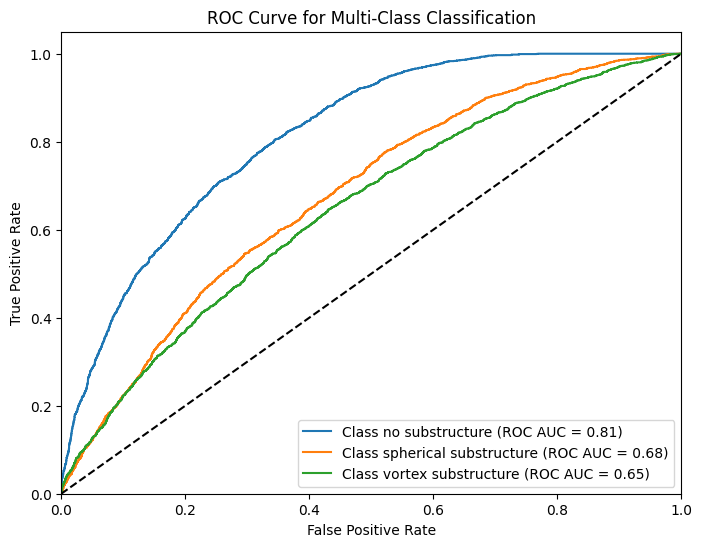

TrainLoss =  1.0278949451446533   ValidationLoss =  0.9492990397135417
lr =  0.00040002431294243294
Best Model Saved
Epoch no. = 6
--------------------------------------------------------------------------------


100%|██████████| 235/235 [00:15<00:00, 15.29it/s]


Accuracy: 0.5533333333333333
ROC AUC Score: 0.8071064666666666


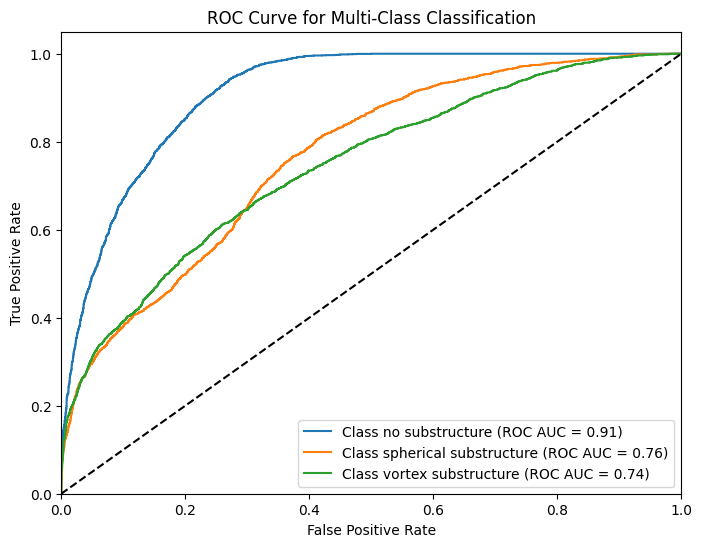

TrainLoss =  0.8312818217595418   ValidationLoss =  1.0069437156995138
lr =  0.0004000273553190544
Epoch no. = 7
--------------------------------------------------------------------------------


100%|██████████| 235/235 [00:15<00:00, 15.02it/s]


Accuracy: 0.7665333333333333
ROC AUC Score: 0.9208379733333333


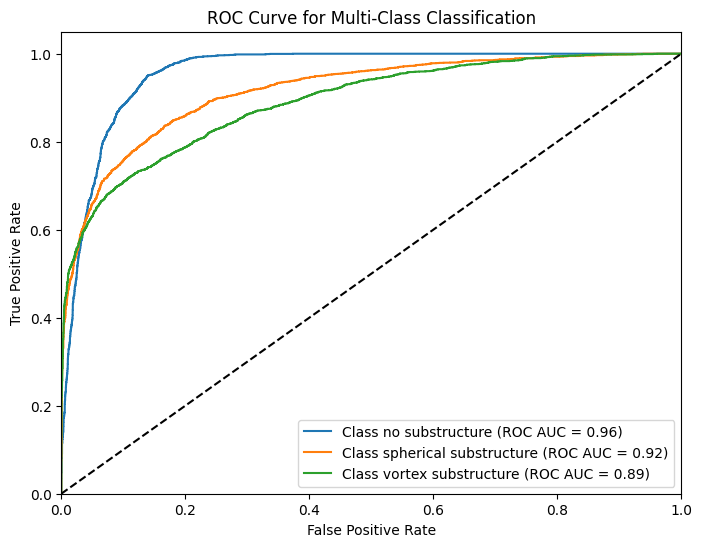

TrainLoss =  0.6055300693511962   ValidationLoss =  0.593491757774353
lr =  0.0004000095030069293
Best Model Saved
Epoch no. = 8
--------------------------------------------------------------------------------


100%|██████████| 235/235 [00:15<00:00, 15.10it/s]


Accuracy: 0.826
ROC AUC Score: 0.9485439066666667


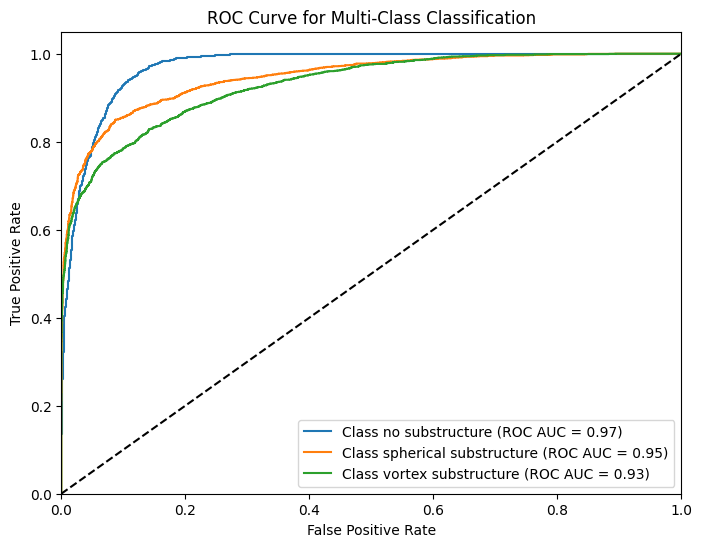

TrainLoss =  0.44830303257306414   ValidationLoss =  0.45976494029362996
lr =  0.0004000057030006457
Best Model Saved
Epoch no. = 9
--------------------------------------------------------------------------------


100%|██████████| 235/235 [00:15<00:00, 14.96it/s]


Accuracy: 0.8721333333333333
ROC AUC Score: 0.9689504800000001


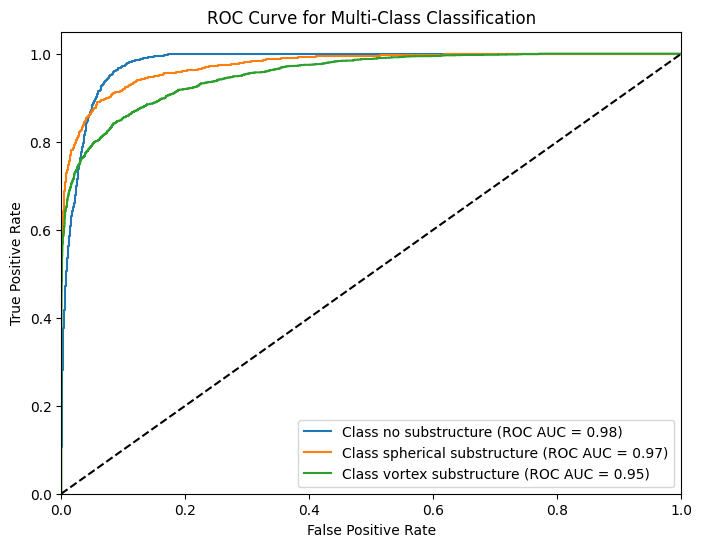

TrainLoss =  0.35679001462459564   ValidationLoss =  0.32410584632555645
lr =  0.00040000283403684826
Best Model Saved
Epoch no. = 10
--------------------------------------------------------------------------------


100%|██████████| 235/235 [00:15<00:00, 15.09it/s]


Accuracy: 0.7306666666666667
ROC AUC Score: 0.9494366666666666


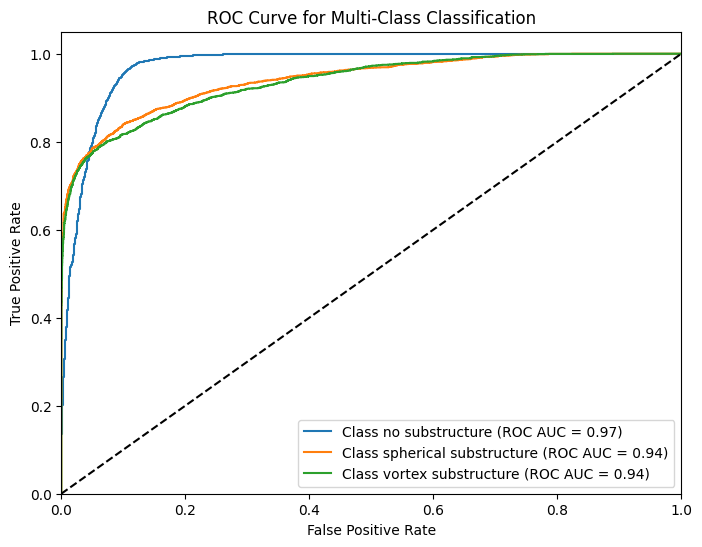

TrainLoss =  0.2984729272445043   ValidationLoss =  0.6833356518745423
lr =  0.0004000125979469471


In [21]:
trainloss =[]
valloss = []
bestloss = np.inf
for i in range(config.EPOCHS):
    print("Epoch no. =" ,i+1)
    print("-"*80)
    trainl = trainer(meramodel,trainloader,optimizer,criterion,device)
    vall = tester(meramodel,testloader,criterion,device)
    trainloss.append(trainl)
    valloss.append(vall)
    scheduler.step(vall)
    print("TrainLoss = ",trainl," ","ValidationLoss = ",vall)
    lr=scheduler.get_last_lr()[0]
    print("lr = ",lr)
    if bestloss>vall:
        bestloss = vall
        torch.save({
            'model':meramodel.state_dict(),
            'optimizer':optimizer.state_dict()},
        './Bestmodel.model'
        )
        print("Best Model Saved")
    print("="*80)